In [19]:
import warnings
warnings.simplefilter('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from tensorflow.keras import regularizers
sns.set_context('notebook')
sns.set_style('white')

In [2]:
np.random.seed(71)
tf.random.set_seed(71)
random.seed(71)

In [3]:
raw_dataset = pd.read_csv('Bike-Sharing-Dataset/day.csv')
raw_dataset.sample(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
32,33,2011-02-02,1,0,2,0,3,1,2,0.260000,0.254417,0.775417,0.264308,72,1454,1526
429,430,2012-03-05,1,1,3,0,1,1,1,0.243333,0.241171,0.506250,0.228858,203,3130,3333
22,23,2011-01-23,1,0,1,0,0,0,1,0.096522,0.098839,0.436522,0.246600,150,836,986
675,676,2012-11-06,4,1,11,0,2,1,1,0.280833,0.281567,0.567083,0.173513,466,5220,5686
469,470,2012-04-14,2,1,4,0,6,0,1,0.495000,0.487996,0.502917,0.190917,2795,4665,7460
488,489,2012-05-03,2,1,5,0,4,1,2,0.560000,0.537242,0.768333,0.133696,764,5657,6421
237,238,2011-08-26,3,0,8,0,5,1,1,0.700000,0.659733,0.761250,0.083962,768,3893,4661
575,576,2012-07-29,3,1,7,0,0,0,1,0.721667,0.667933,0.623750,0.170396,2153,4444,6597
615,616,2012-09-07,3,1,9,0,5,1,1,0.703333,0.657204,0.736250,0.171646,1045,6459,7504
636,637,2012-09-28,4,1,9,0,5,1,2,0.619167,0.585863,0.690000,0.164179,1045,6370,7415


Let's first clean the data, it involves removing columns that are either non-numerical, redundant, or could lead to data leakage. We drop the `dteday`column as we already have numerical date features like `mnth`, `yr`, and `weekday`. The `instant` column, being just a row identifier, is unnecessary for analysis. We also remove `registered` and `casual` columns, as their sum equals the target variable `cnt`, and including them would risk data leakage.

In [4]:
raw_dataset = raw_dataset.drop(columns=['dteday', 'instant', 'registered', 'casual'])
raw_dataset.sample(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
111,2,0,4,0,5,1,2,0.336667,0.321954,0.729583,0.219521,1683
435,1,1,3,0,0,0,1,0.361739,0.359670,0.476957,0.222587,4911
651,4,1,10,0,6,0,1,0.393333,0.391396,0.494583,0.146142,7109
346,4,0,12,0,2,1,1,0.282500,0.301138,0.590000,0.140550,3523
350,4,0,12,0,6,0,2,0.258333,0.249371,0.560833,0.243167,2739
231,3,0,8,0,6,0,1,0.697500,0.648996,0.674167,0.104467,5191
91,2,0,4,0,6,0,2,0.315000,0.315637,0.653750,0.197146,2252
149,2,0,5,1,1,0,1,0.733333,0.671092,0.685000,0.131225,4098
420,1,1,2,0,6,0,1,0.290833,0.255675,0.395833,0.421642,2732
700,4,1,12,0,6,0,2,0.298333,0.316904,0.806667,0.059704,5191


From the output above, we can observe that the left seven columns represent categorical features, while the right four columns are numerical features. Next, we will create box plots for the categorical features and scatter plots for the numerical features to explore the relationship between individual features and the target variable cnt. This analysis will help us identify which factors might influence the number of rental bikes, enabling us to make better decisions for modeling and feature selection in subsequent steps.

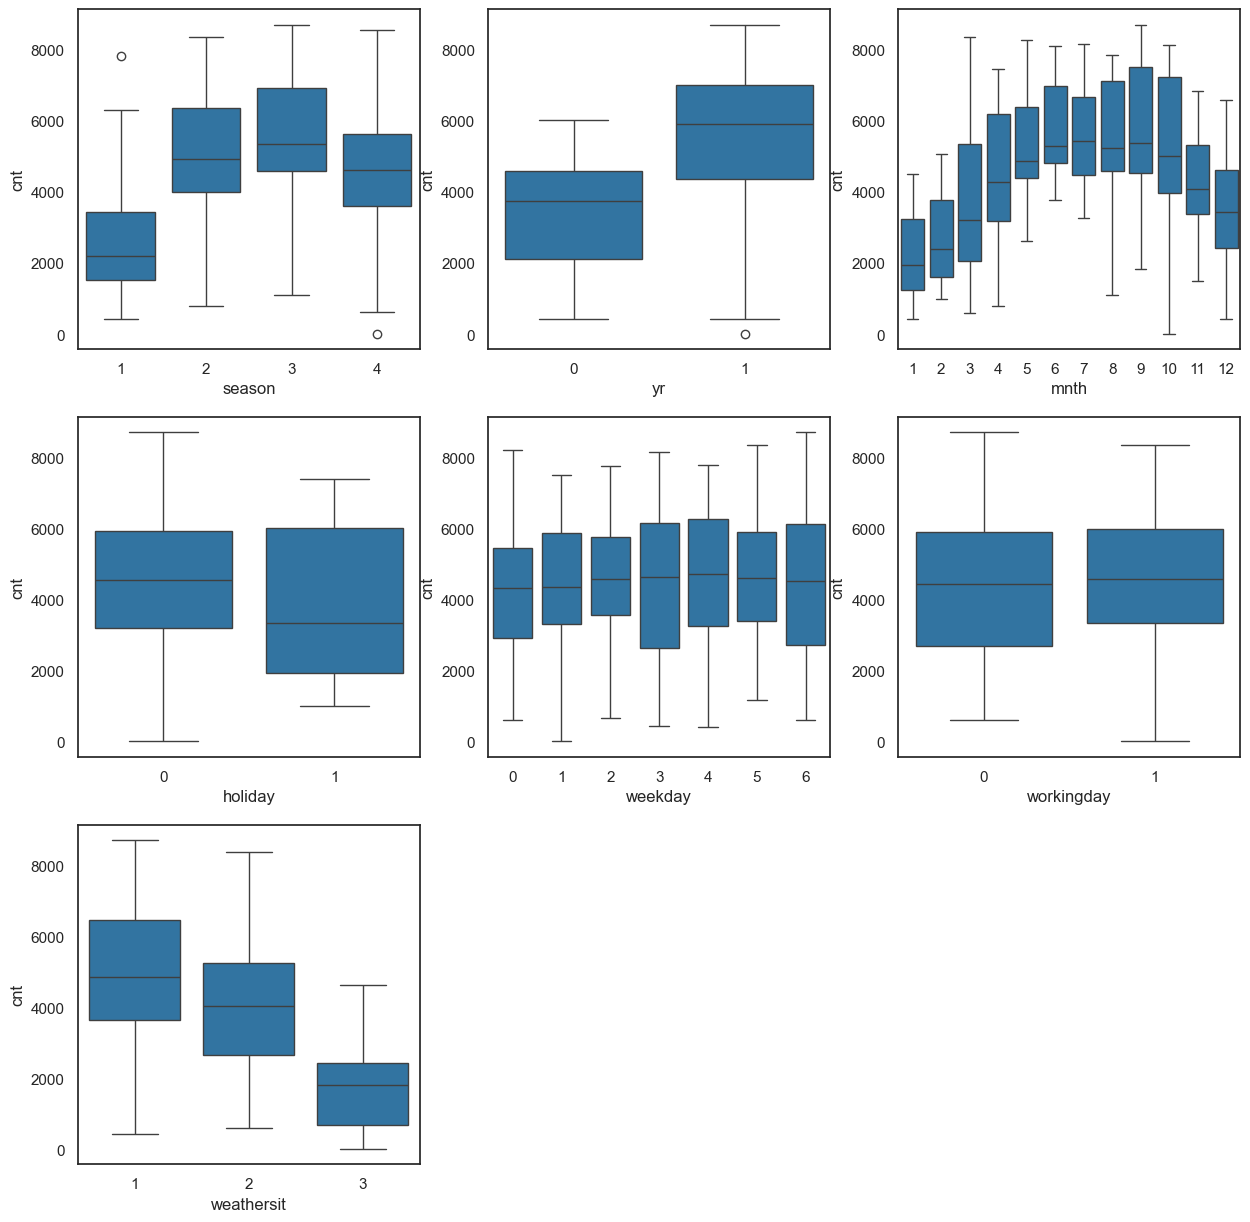

In [5]:
col = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
plt.figure(figsize=[15,15])
for i in enumerate(col):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(data=raw_dataset,x=i[1],y='cnt')
plt.show()

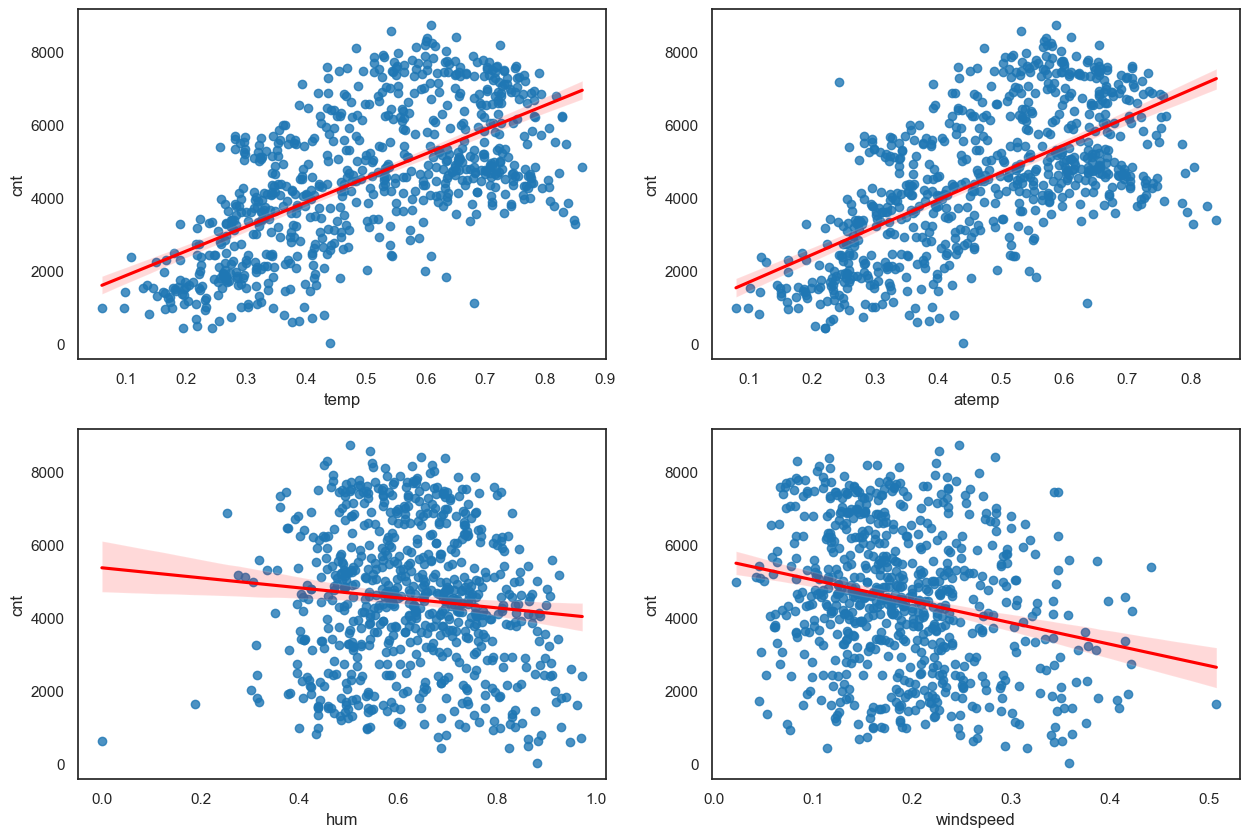

In [7]:
col = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=[15,10])
for i in enumerate(col):
    plt.subplot(2,2,i[0]+1)
    sns.regplot(data=raw_dataset,x=i[1],y='cnt',line_kws={"color":'red'})
plt.show()

The analysis reveals that there is a positive correlation between `temp` and `atemp` with `cnt`, indicating that higher temperatures are associated with increased bike rentals. Conversely, there is a negative correlation between `windspeed` and `hum` with `cnt`, suggesting that higher wind speeds and humidity levels may decrease bike usage. Additionally, bike rental demand is highest in the fall and lowest in the spring. There was an observed increase in bike rentals in 2019 compared to 2018. Bike rentals are also more frequent on non-holidays compared to holidays, and clear weather conditions are preferred over light rain, thunderstorms, and snowy days.

To better understand the relationships between various features and identify potential correlations, we perform a multivariate analysis and visualize the correlations using a heatmap.

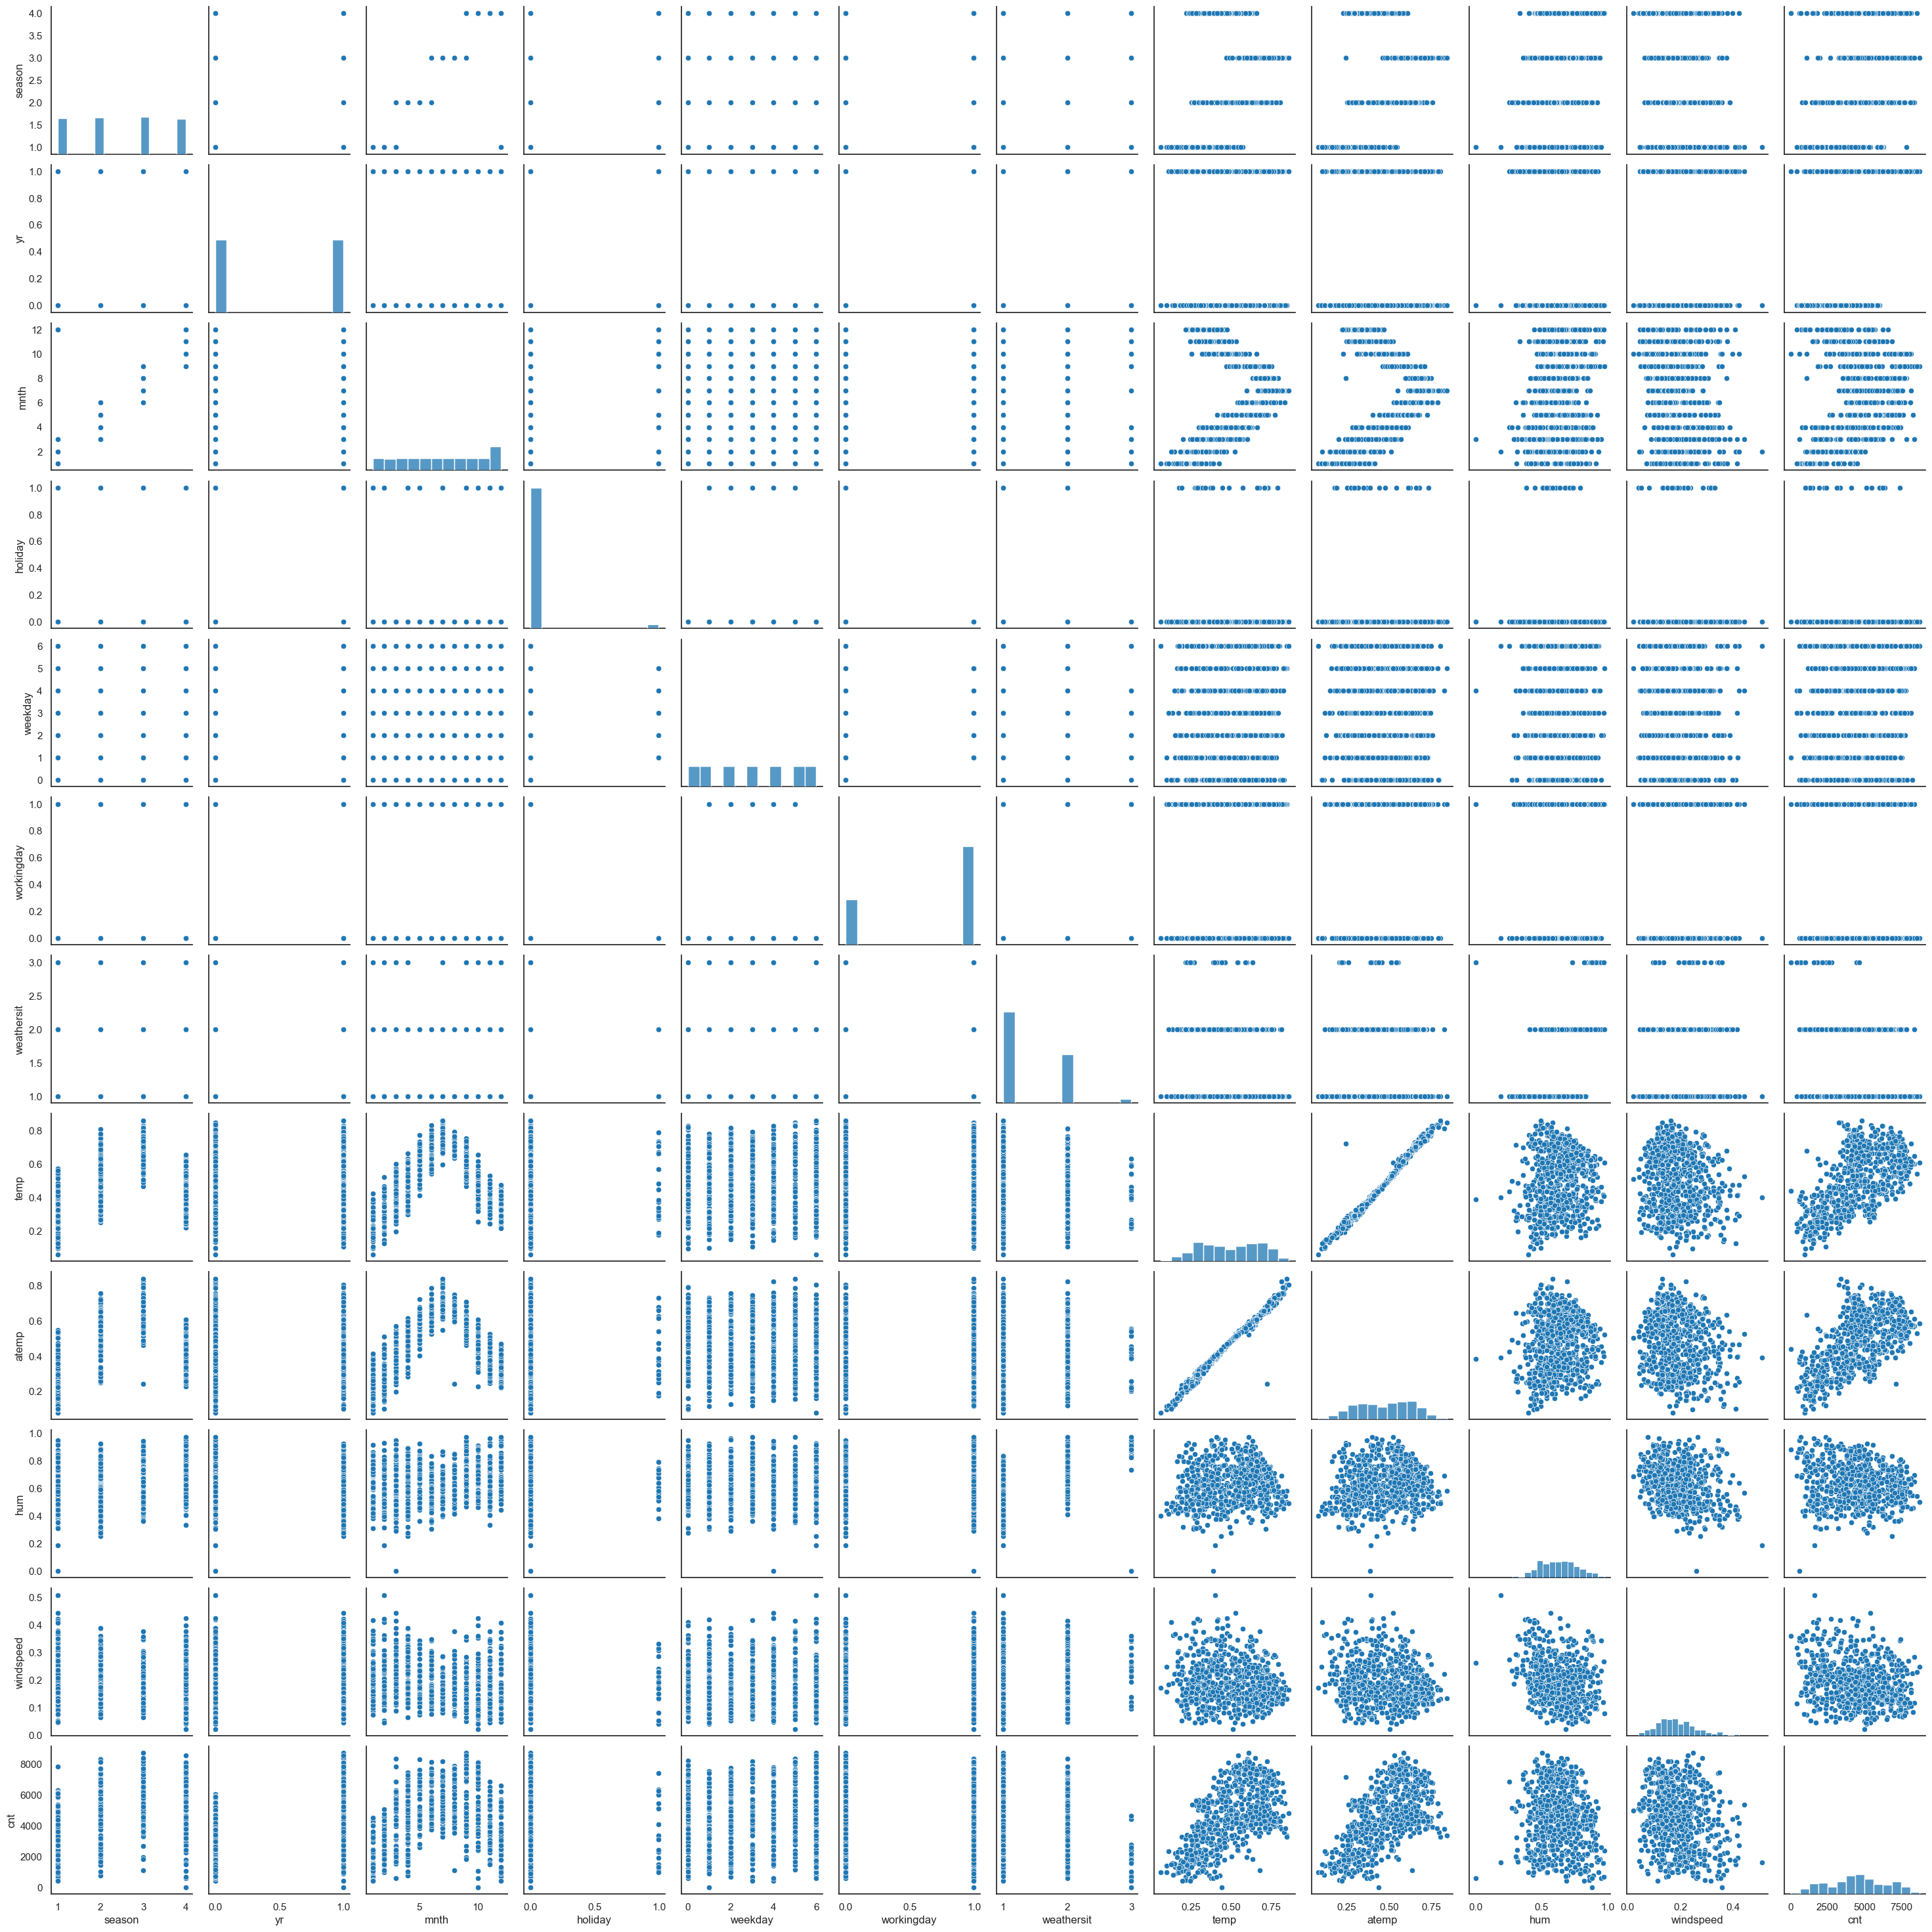

In [8]:
sns.pairplot(raw_dataset)

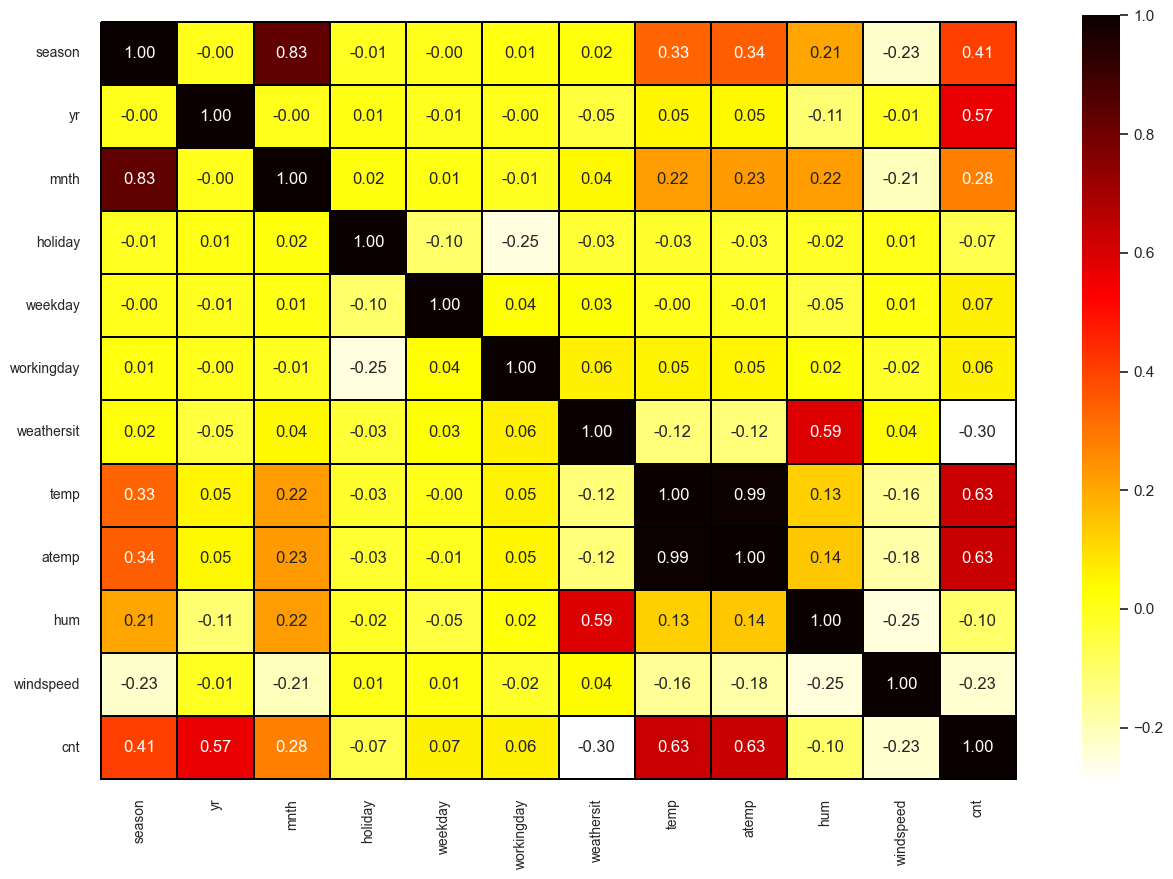

In [9]:
plt.figure(figsize=[15,10])
fig = sns.heatmap(raw_dataset.corr(),cmap='hot_r',
            annot=True,linecolor='black',linewidths=0.01,annot_kws={"fontsize":12},fmt="0.2f")
top, bottom = fig.get_ylim()
fig.set_ylim(top+0.1,bottom-0.1)
left, right = fig.get_xlim()
fig.set_xlim(left-0.1,right+0.1) 
plt.yticks(fontsize=10,rotation=0)
plt.xticks(fontsize=10,rotation=90);

The heatmap indicates several key relationships among variables. `temp` and `atemp` have a near-perfect correlation, which is expected since `atemp` represents the "feels like" temperature. Both `temp` and `atemp` are strongly positively correlated with `cnt`, suggesting that higher temperatures lead to more bike rentals. Additionally, `yr` shows a significant positive correlation with `cnt`, indicating an increase in bike rentals in `2012` compared to `2011`. The `season` variable also has a moderate positive correlation with `cnt`, while `weathersit` shows a moderate negative correlation, implying that adverse weather conditions reduce bike rentals. On the other hand, variables like `holiday`, `weekday`, and `workingday` exhibit weak or negligible correlations with `cnt`, suggesting minimal impact on bike rentals. Finally, `windspeed` and `hum` have slight negative correlations with `cnt`, indicating that higher wind speeds and humidity may slightly decrease the number of bike rentals.

Now we split the dataset into training and testing sets and separates the features from the target labels for model training and evaluation.

In [10]:
train_dataset = raw_dataset.sample(frac=0.8) #80%
test_dataset = raw_dataset.drop(train_dataset.index) #20%
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('cnt')
test_labels = test_features.pop('cnt')

In [31]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [24]:
def create_model():
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
                  loss='mean_squared_error')
    return model

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid(True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE:
959.6739281870251
Column names
Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')
—————————————————————
Layer Name: normalization
Weights
Shape: (11,) 
 [2.48547    0.50085473 6.535043   0.02735043 3.0410256  0.6820513
 1.3965812  0.49445498 0.4733224  0.6257107  0.18994804]
Bias
Shape: (11,) 
 [1.2309855e+00 2.4999927e-01 1.1910311e+01 2.6602382e-02 4.0769496e+00
 2.1685733e-01 3.0426180e-01 3.4053754e-02 2.6864007e-02 2.0465458e-02
 5.8970884e-03] 

—————————————————————
Layer Name: dense_21
Weights
Shape: (11, 1) 
 [[ 373.16345 ]
 [ 985.20935 ]
 [  46.689335]
 [ -73.67696 ]
 [ 105.32156 ]
 [  75.19095 ]
 [-300.28705 ]
 [ 500.87402 ]
 [ 499.95135 ]
 [-158.54419 ]
 [-182.82877 ]]
Bias
Shape: (1,) 
 [4309.7017] 



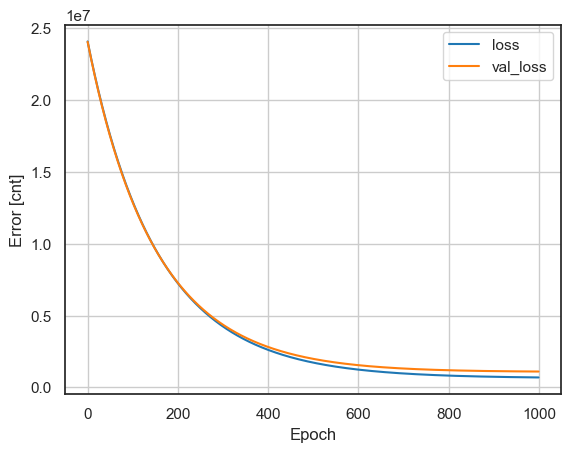

In [29]:
linear_model = create_model()

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split=0.2
)

y_pred = linear_model.predict(test_features)

print("MSE:")
print(np.sqrt(metrics.mean_squared_error(test_labels, y_pred)))

print("Column names")
print(test_features.columns)

for layer in linear_model.layers:
    print("—————————————————————")
    print("Layer Name:", layer.name)
    print("Weights")
    print("Shape:", layer.get_weights()[0].shape, '\n', layer.get_weights()[0])
    print("Bias")
    print("Shape:", layer.get_weights()[1].shape, '\n', layer.get_weights()[1], '\n')

plot_loss(history)

In conclusion, the model’s weights align well with the relationships indicated by the heatmap. For example, the high weights assigned to `temp` and `atemp` suggest that the model has successfully learned that temperature positively influences bike rentals. Similarly, lower or negative weights for `weathersit` and `windspeed` reflect their negative impact on rentals, as highlighted in the heatmap analysis. This consistency indicates that our model is capturing the key factors affecting bike rentals, suggesting it has a good understanding of the underlying patterns in the data.